In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from tqdm.auto import tqdm
import sed_analysis_tools as st
importlib.reload(st)
# optimistic filters
x_optimistic = np.linspace(3.13, 4.70, 50)

# realistic filters
x_realistic = np.linspace(3.13, 4.70, 15)

# gaia xp filters
'''
https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_spectroscopic_tables/ssec_dm_xp_sampled_mean_spectrum.html
'''
x_gaia = np.log10(10*np.linspace(336,1020, 343))

# uocs filters
x_uocs=np.log10([1481,1541,1608, #UVIT
                 2196,2418,2447,2632, #UVIT
                 1548,2303, #GALEX
                 5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ])

# optical-IR filters
x_optical_IR=np.log10([5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ])


## General HRD Grids

In [2]:
logT_A_list = np.linspace(3.5,5.1,9)
logL_A_list = np.full(len(logT_A_list),0)
logT_B_list = np.linspace(3.4,5.2,10)
logL_B_list = np.linspace(-4.5,0,10)
frac_err_list = np.logspace(-4,0,9)[:-2]

logT_B_list = np.linspace(3.4,5.2,10)
logL_B_list = np.linspace(-4.5,0,10)
logT_B_list, logL_B = np.meshgrid(logT_B_list, logL_B_list)
logT_B_list, logL_B_list = logT_B_list.flatten(), logL_B.flatten()

T3.70_sigma0.0100_optimistic


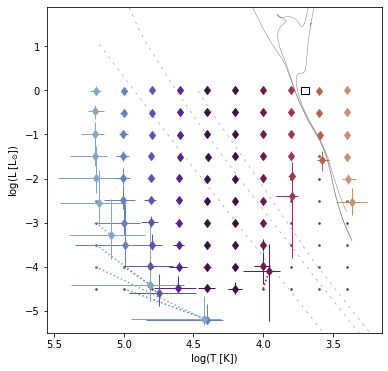

In [4]:
def _plot_isochrone_and_wd(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    iso = pd.read_csv(st.DIR_MODELS+'master_isochrone.csv')
    iso_8 = iso[iso.logAge == 8]
    iso_9 = iso[iso.logAge == 9]
    iso_10 = iso[iso.logAge == 10]
    ax.plot((iso_8.logTe), (iso_8.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_9.logTe), (iso_9.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_10.logTe), (iso_10.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)

    Bergeron_WD = pd.read_csv(st.DIR_MODELS + 'master_Bergeron_WD.csv')
    WD_02 = Bergeron_WD[(Bergeron_WD.mass == 0.2) &
                        (Bergeron_WD.spectral_type == 'DA')]
    WD_05 = Bergeron_WD[(Bergeron_WD.mass == 0.5) &
                        (Bergeron_WD.spectral_type == 'DA')]
    WD_13 = Bergeron_WD[(Bergeron_WD.mass == 1.3) &
                        (Bergeron_WD.spectral_type == 'DA')]
    ax.plot(np.log10(WD_02.Teff), WD_02.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    ax.plot(np.log10(WD_05.Teff), WD_05.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    ax.plot(np.log10(WD_13.Teff), WD_13.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    
fig, ax = plt.subplots(figsize=(6,6))
for idx, _logT in (enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        if index==11:
            grid = st.Grid(T_A = 10**_logT *u.K, 
                        L_A = 1 *u.solLum, 
                        logT_B_list = logT_B_list, 
                        logL_B_list = logL_B_list, 
                        niter=50,
                        frac_err=frac_err,
                        name='T%.2f_sigma%.4f_optimistic'%(_logT,frac_err),
                        x=x_optimistic)
            grid.calculate_params(refit=False)
            grid.plot_skeleton(ax=ax)
            grid.plot_Double_fitting_points(ax=ax, noisy=False)
            print(grid.name)

ax.set_ylim(-5.5,1.9)
ax.set_xlim(5.55,3.15)
ax.set_ylabel('log(L [L$_⊙$])')
ax.set_xlabel('log(T [K])')
_plot_isochrone_and_wd(ax)
plt.savefig('plots/public/demo_hrd_grid.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/demo_hrd_grid.pdf', dpi=300, bbox_inches='tight')

9it [00:13,  1.46s/it]


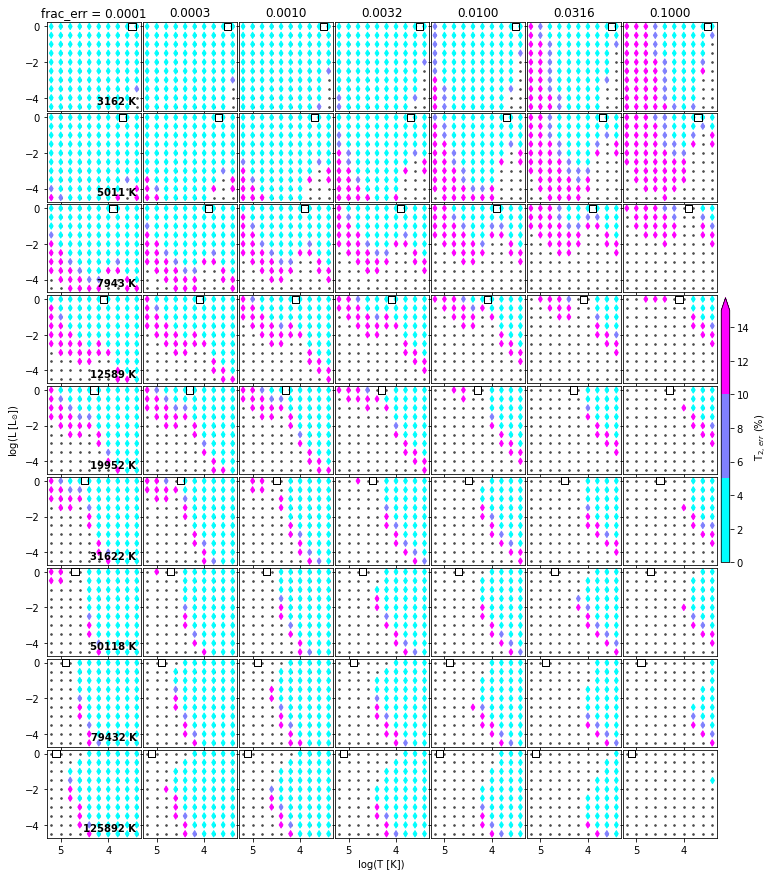

In [5]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

logT_A_list = np.linspace(3.5,5.1,9)[:]
frac_err_list = np.logspace(-4,-1,7)[:]

ncols=len(frac_err_list)
nrows=len(logT_A_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.03)
cax = ax[4,6].inset_axes([1.05, -1, 0.09, 3])


for idx, _logT in st.tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        # if (idx<3) & (jdx<3):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_optimistic'%(_logT,frac_err),
                    x=x_optimistic)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx])
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('frac_err = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%d K'%10**_logT, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
                
ax[0,0].invert_xaxis()
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[8,3].set_xlabel('log(T [K])')

plt.savefig('plots/public/hrd_optimistic.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_optimistic.pdf', dpi=300, bbox_inches='tight')

9it [00:14,  1.67s/it]


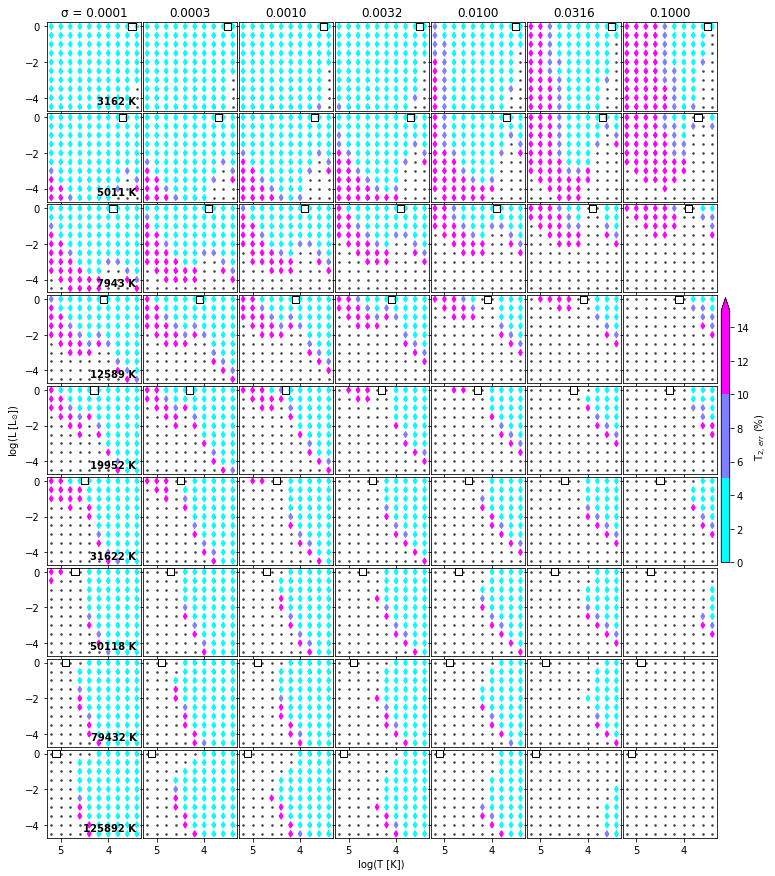

In [6]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

logT_A_list = np.linspace(3.5,5.1,9)[:]
frac_err_list = np.logspace(-4,-1,7)[:]

ncols=len(frac_err_list)
nrows=len(logT_A_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.03)
cax = ax[4,6].inset_axes([1.05, -1, 0.09, 3])


for idx, _logT in st.tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_realistic'%(_logT,frac_err),
                    x=x_realistic)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx])
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%d K'%10**_logT, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
                
ax[0,0].invert_xaxis()
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[8,3].set_xlabel('log(T [K])')

plt.savefig('plots/public/hrd_realistic.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_realistic.pdf', dpi=300, bbox_inches='tight')

In [ ]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

logT_A_list = np.linspace(3.5,5.1,9)[:]
frac_err_list = np.logspace(-4,-1,7)[:]

ncols=len(frac_err_list)
nrows=len(logT_A_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.03)
cax = ax[4,6].inset_axes([1.05, -1, 0.09, 3])


for idx, _logT in st.tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_gaia'%(_logT,frac_err),
                    x=x_gaia)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx])
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%d K'%10**_logT, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
                
ax[0,0].invert_xaxis()
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[8,3].set_xlabel('log(T [K])')

plt.savefig('plots/public/hrd_gaia.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_gaia.pdf', dpi=300, bbox_inches='tight')

In [ ]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

logT_A_list = np.linspace(3.5,5.1,9)[:]
frac_err_list = np.logspace(-4,-1,7)[:]

ncols=len(frac_err_list)
nrows=len(logT_A_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.03)
cax = ax[4,6].inset_axes([1.05, -1, 0.09, 3])


for idx, _logT in st.tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_uocs'%(_logT,frac_err),
                    x=x_uocs)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx])
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%d K'%10**_logT, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
                
ax[0,0].invert_xaxis()
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[8,3].set_xlabel('log(T [K])')

plt.savefig('plots/public/hrd_uocs.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_uocs.pdf', dpi=300, bbox_inches='tight')

In [ ]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

logT_A_list = np.linspace(3.5,5.1,9)[:]
frac_err_list = np.logspace(-4,-1,7)[:]

ncols=len(frac_err_list)
nrows=len(logT_A_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.03)
cax = ax[4,6].inset_axes([1.05, -1, 0.09, 3])


for idx, _logT in st.tqdm(enumerate(logT_A_list[:])):
    for jdx, frac_err in enumerate(frac_err_list[:]):
        grid = st.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=10,
                    frac_err=frac_err,
                    name='T%.2f_sigma%.4f_optIR'%(_logT,frac_err),
                    x=x_optical_IR)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx])
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%d K'%10**_logT, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
                
ax[0,0].invert_xaxis()
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[8,3].set_xlabel('log(T [K])')

plt.savefig('plots/public/hrd_optIR.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_optIR.pdf', dpi=300, bbox_inches='tight')

## Unresolved binaries with Gaia XP

In [7]:
zams = pd.read_csv(st.DIR_MODELS+'master_ZAMS.csv')
zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.9,1.0,1.2,1.5,2.0,2.5,3.0,4.0,5.0,6.0,8.0,10.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
frac_err_list = np.logspace(-4,-1,7)[:-1]
print(mass_list, '\n',logT_A_list, '\n',logL_A_list)
print(frac_err_list)


def _plot_isochrone_and_wd(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    iso = pd.read_csv(st.DIR_MODELS+'master_isochrone.csv')
    iso_8 = iso[iso.logAge == 8]
    iso_9 = iso[iso.logAge == 9]
    iso_10 = iso[iso.logAge == 10]
    ax.plot((iso_8.logTe), (iso_8.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_9.logTe), (iso_9.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_10.logTe), (iso_10.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)

[0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0] 
 [3.73130222 3.75960804 3.8041     3.8655     3.9765     4.04995976
 4.1042     4.18303567 4.24364719 4.2912     4.35817123 4.40974122] 
 [-0.3318039  -0.11695627  0.267       0.718       1.24        1.62019299
  1.926       2.39660155  2.74830951  3.025       3.45681497  3.76927827]
[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278]


M1.00_sigma0.0032_gaia


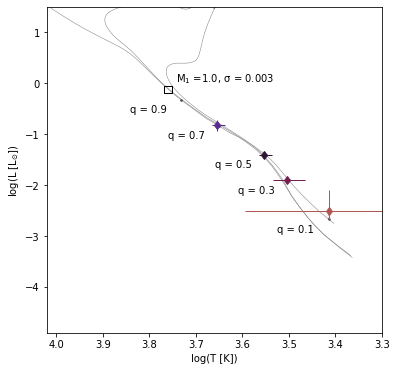

In [8]:
importlib.reload(st)
fig, ax = plt.subplots(figsize=(6,6))
for idx, mass in enumerate(mass_list):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]
    q_list = np.array([0.1,0.3,0.5,0.7,0.9])
    secondary_mass_list = mass_list[idx] * q_list
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        if index==9:
            grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_gaia'%(mass, frac_err),
                    logT_B_list=logT_B_list,
                    logL_B_list=logL_B_list,
                    x=x_gaia)
            print(grid.name)
        
            grid.calculate_params(refit=False)
            grid.plot_skeleton(ax=ax)
            grid.plot_Double_fitting_points(ax=ax, noisy=False)
            _plot_isochrone_and_wd(ax=ax)
            for kdx, q in enumerate(q_list):
                ax.text(logT_B_list[kdx]+0.11,logL_B_list[kdx]-0.19,'q = %.1f'%q, va='center')
            ax.text(np.log10(T_A)-0.01, np.log10(L_A)+0.15,' M$_1$ =%.1f, σ = %.3f'%(mass,frac_err))
ax.set_ylim(-4.9,1.5)
ax.set_xlim(4.02,3.3)

ax.set_ylabel('log(L [L$_⊙$])')
ax.set_xlabel('log(T [K])')
plt.savefig('plots/public/demo_hrd_unresolved.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/demo_hrd_unresolved.pdf', dpi=300, bbox_inches='tight')

12it [00:13,  1.10s/it]


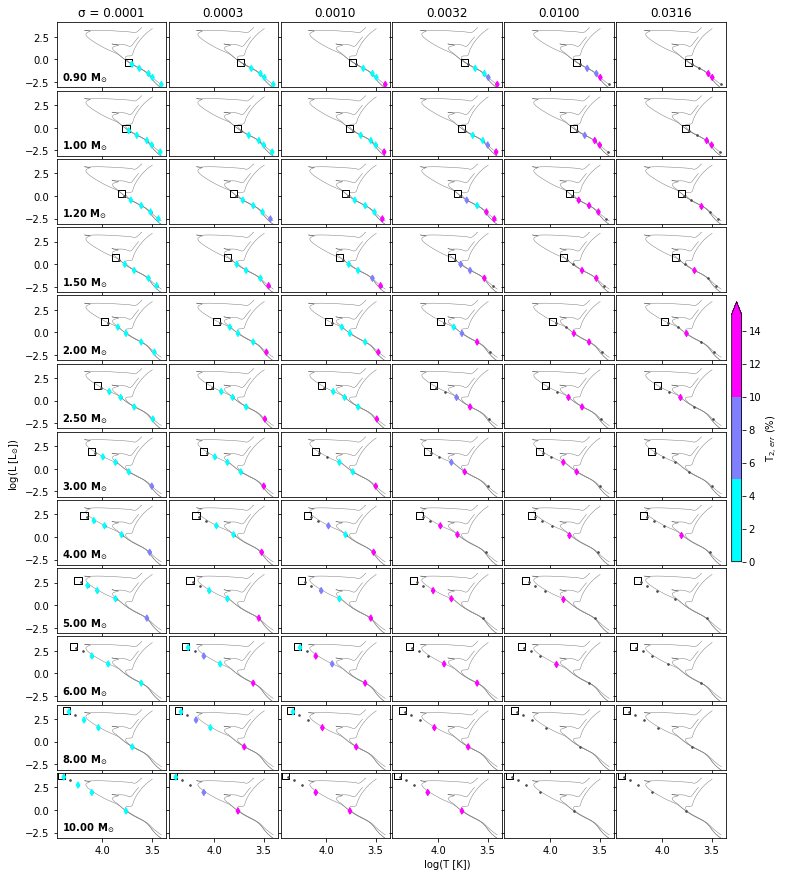

In [9]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

ncols=len(frac_err_list)
nrows=len(mass_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.05)
cax = ax[6,ncols-1].inset_axes([1.05, -1, 0.09, 4])

for idx, mass in tqdm(enumerate(mass_list)):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]

    secondary_mass_list = mass_list[idx] * np.array([0.1,0.3,0.5,0.7,0.9])
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_gaia'%(mass, frac_err),
                    logT_B_list=logT_B_list,
                    logL_B_list=logL_B_list,
                    x=x_gaia)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx], zorder=-2)
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.05, 0.05, '%.2f M$_⊙$'%mass, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='left',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
        
ax[0,0].invert_xaxis()
ax[0,0].set_xlim(ax[0,0].get_xlim())
ax[0,0].set_ylim(ax[0,0].get_ylim())
ax[6,0].set_ylabel('log(L [L$_⊙$])')
ax[nrows-1,3].set_xlabel('log(T [K])')

for idx in range(nrows):
    for jdx in range(ncols):
         _plot_isochrone_and_wd(ax=ax[idx,jdx])

plt.savefig('plots/public/hrd_unresolved_gaia.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_unresolved_gaia.pdf', dpi=300, bbox_inches='tight')

## Hotter companions

In [21]:
zams = pd.read_csv(st.DIR_MODELS+'master_ZAMS.csv')
zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.5,3.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
print(mass_list, '\n', logT_A_list, '\n', logL_A_list)

frac_err_list = np.logspace(-3,-1,5)[:]
print(frac_err_list)

logT_B_list = np.linspace(4.7,3.95,10)
logL_B_list = np.linspace(-3,1.5,11)
logT_B_list, logL_B_list = np.meshgrid(logT_B_list, logL_B_list)
i = np.indices(logT_B_list.shape)
_filter_1 = (i[0]+i[1]<17).flatten()
_filter_2 = (i[0]+i[1]>1).flatten()
_filter = (_filter_1&_filter_2)
logT_B_list = logT_B_list.flatten()[_filter]
logL_B_list = logL_B_list.flatten()[_filter]



def _plot_isochrone_and_wd(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    iso = pd.read_csv(st.DIR_MODELS+'master_isochrone.csv')
    iso_8 = iso[iso.logAge == 8]
    iso_9 = iso[iso.logAge == 9]
    iso_10 = iso[iso.logAge == 10]
    ax.plot((iso_8.logTe), (iso_8.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_9.logTe), (iso_9.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)
    ax.plot((iso_10.logTe), (iso_10.logL), label='',
            c='0.5', lw=0.5, rasterized=True, zorder=-5)

    Bergeron_WD = pd.read_csv(st.DIR_MODELS + 'master_Bergeron_WD.csv')
    WD_02 = Bergeron_WD[(Bergeron_WD.mass == 0.2) &
                        (Bergeron_WD.spectral_type == 'DA')]
    WD_05 = Bergeron_WD[(Bergeron_WD.mass == 0.5) &
                        (Bergeron_WD.spectral_type == 'DA')]
    WD_13 = Bergeron_WD[(Bergeron_WD.mass == 1.3) &
                        (Bergeron_WD.spectral_type == 'DA')]
    ax.plot(np.log10(WD_02.Teff), WD_02.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    ax.plot(np.log10(WD_05.Teff), WD_05.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    ax.plot(np.log10(WD_13.Teff), WD_13.logL, label='', c='0.5',
            ls=(0, (5, 10)), lw=0.5, rasterized=True, zorder=1)
    

[0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0] 
 [3.6961     3.75960804 3.8041     3.8421     3.8922     3.93910271
 3.9765     4.04995976 4.1042    ] 
 [-0.569      -0.11695627  0.267       0.583       0.842       1.05397301
  1.24        1.62019299  1.926     ]
[0.001      0.00316228 0.01       0.03162278 0.1       ]


M1.00_sigma0.0100_uocs
M1.00_sigma0.0100_optIR


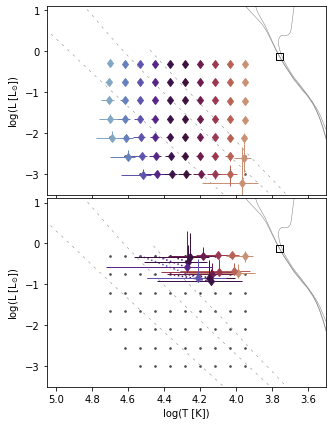

In [22]:
# fig, ax = plt.subplots(figsize=(6,8), nrows=2, sharex=True, sharey=True)
fig, ax = plt.subplots(figsize=(5,7), nrows=2, sharex=True, sharey=True)

fig.subplots_adjust(hspace=0.02)

plot_index=7
for idx, mass in enumerate(mass_list[:]):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        if index == plot_index:
            grid = st.Grid(T_A = T_A*u.K, 
                L_A = L_A*u.solLum, 
                niter=50,
                frac_err=frac_err,
                name='M%.2f_sigma%.4f_uocs'%(mass,frac_err),
                logT_B_list=logT_B_list[_filter],
                logL_B_list=logL_B_list[_filter],
                x=x_uocs)
            grid.calculate_params(refit=False)
            grid.plot_skeleton(ax=ax[0])
            grid.plot_Double_fitting_points(ax=ax[0], noisy=False)
            print(grid.name)

for idx, mass in enumerate(mass_list[:]):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        if index == plot_index:
            grid = st.Grid(T_A = T_A*u.K, 
                L_A = L_A*u.solLum, 
                niter=50,
                frac_err=frac_err,
                name='M%.2f_sigma%.4f_optIR'%(mass,frac_err),
                logT_B_list=logT_B_list[_filter],
                logL_B_list=logL_B_list[_filter],
                x=x_optical_IR)
            grid.calculate_params(refit=False)
            grid.plot_skeleton(ax=ax[1])
            grid.plot_Double_fitting_points(ax=ax[1], noisy=False)
            print(grid.name)
ax[0].set_ylim(-3.5,1.1)
ax[0].set_xlim(5.05,3.5)

ax[0].set_ylabel('log(L [L$_⊙$])')
ax[1].set_ylabel('log(L [L$_⊙$])')
ax[1].set_xlabel('log(T [K])')
_plot_isochrone_and_wd(ax[0])
_plot_isochrone_and_wd(ax[1])
plt.savefig('plots/public/demo_hrd_hotter_companions.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/demo_hrd_hotter_companions.pdf', dpi=300, bbox_inches='tight')

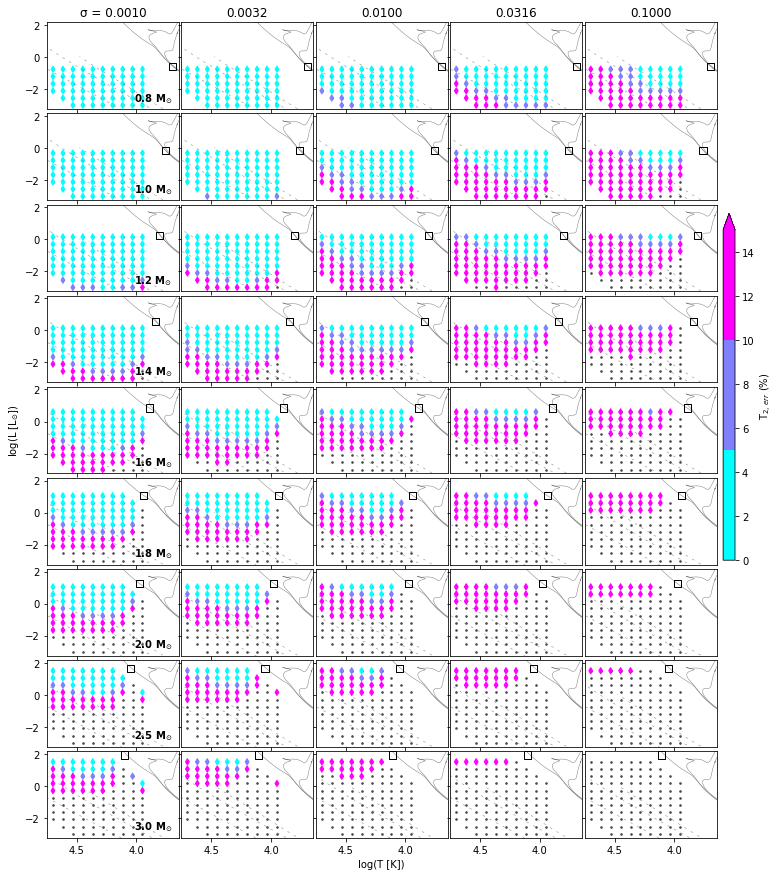

In [15]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

ncols=len(frac_err_list)
nrows=len(mass_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.05)
cax = ax[4,ncols-1].inset_axes([1.05, -1, 0.09, 4])

for idx, mass in enumerate(mass_list[:]):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
            L_A = L_A*u.solLum, 
            niter=50,
            frac_err=frac_err,
            name='M%.2f_sigma%.4f_uocs'%(mass,frac_err),
            logT_B_list=logT_B_list[_filter],
            logL_B_list=logL_B_list[_filter],
            x=x_uocs)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx], zorder=-2)
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%.1f M$_⊙$'%mass, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
            
ax[0,0].invert_xaxis()
ax[0,0].set_xlim(ax[0,0].get_xlim())
ax[0,0].set_ylim(ax[0,0].get_ylim())
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[nrows-1,2].set_xlabel('log(T [K])')

for idx in range(nrows):
    for jdx in range(ncols):
         _plot_isochrone_and_wd(ax=ax[idx,jdx])

plt.savefig('plots/public/hrd_hotter_companions_uocs.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_hotter_companions_uocs.pdf', dpi=300, bbox_inches='tight')

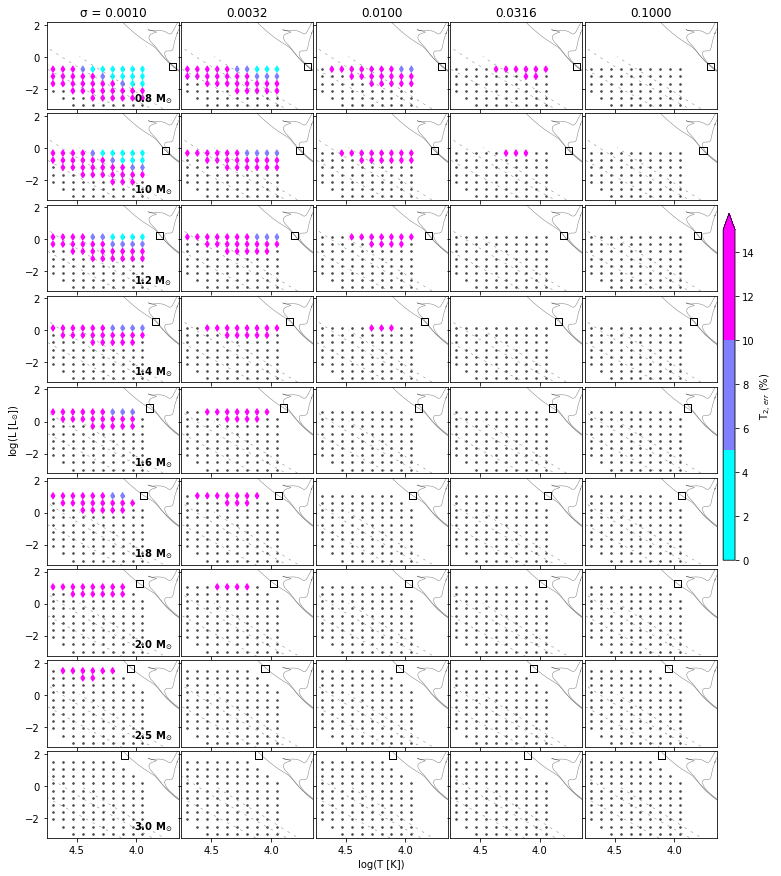

In [16]:
importlib.reload(st)
import warnings
warnings.filterwarnings("ignore")

ncols=len(frac_err_list)
nrows=len(mass_list)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,15), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.02,hspace=0.05)
cax = ax[4,ncols-1].inset_axes([1.05, -1, 0.09, 4])

for idx, mass in enumerate(mass_list[:]):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, frac_err in enumerate(frac_err_list[:]):
        index = jdx+len(frac_err_list)*idx
        grid = st.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    frac_err=frac_err,
                    name='M%.2f_sigma%.4f_optIR'%(mass,frac_err),
                    logT_B_list=logT_B_list[_filter],
                    logL_B_list=logL_B_list[_filter],
                    x=x_optical_IR)
        grid.calculate_params(refit=False)
        grid.plot_skeleton(ax[idx, jdx], zorder=-2)
        colorbar = False
        if idx==0:
            if jdx==0:
                ax[idx, jdx].set_title('σ = %.4f'%frac_err)
                colorbar=True
            else:
                ax[idx, jdx].set_title('%.4f'%frac_err)
        if jdx==0:
            ax[idx,jdx].text(0.95, 0.05, '%.1f M$_⊙$'%mass, fontsize=10, 
                            transform=ax[idx,jdx].transAxes, ha='right',va='bottom', weight='bold')
        grid.plot_Double_fitting_T2err(ax[idx, jdx], s=20, cax=cax, zorder=-1, colorbar=colorbar)
            
ax[0,0].invert_xaxis()
ax[0,0].set_xlim(ax[0,0].get_xlim())
ax[0,0].set_ylim(ax[0,0].get_ylim())
ax[4,0].set_ylabel('log(L [L$_⊙$])')
ax[nrows-1,2].set_xlabel('log(T [K])')

for idx in range(nrows):
    for jdx in range(ncols):
         _plot_isochrone_and_wd(ax=ax[idx,jdx])

plt.savefig('plots/public/hrd_hotter_companions_optIR.jpg', dpi=300, bbox_inches='tight')
plt.savefig('plots/public/hrd_hotter_companions_optIR.pdf', dpi=300, bbox_inches='tight')

# Error estimation

WOCS2002: Grid params :   0%|          | 0/100 [00:00<?, ?it/s]

WOCS2002
--------
T_in  = [5250.000000]	 [14750.000000]
L_in  = [18.000000]	 [0.093000]
T_fit = [5247.735602 +28.367909-30.143027]	[14766.379136 +2650.819988-1820.000509]
L_fit = [17.953317 +0.180461-0.207411]	[0.092202 +0.042894-0.025599]
Convergence rate:1.00


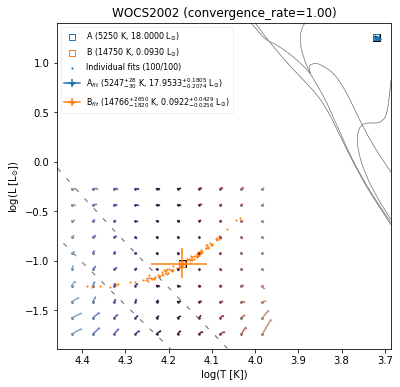

In [ ]:
importlib.reload(st)
'''
Stellar parameters and flux error values are taken from the WOCS2002 star in M67. 
'''
frac_err = [0.05341997, 0.05986721, 0.05341997, 0.02632069, 0.06585393,
     0.00377348, 0.06585393, 0.00276771, 0.00400373, 0.06585393,
     0.00806181, 0.02026275, 0.01842068, 0.01657861, 0.01934171,
     0.01657861, 0.03499929]
x = np.array([3.17055506, 3.18780264, 3.20628604, 3.36236302, 3.63921512,
               3.70206419, 3.72967016, 3.7651012 , 3.88195269, 3.90857131,
               3.93339412, 4.09166696, 4.22063102, 4.33425264, 4.52538174,
               4.6630221 , 5.06298789])
WOCS2002 = st.Binary( T_A = 5250*u.K,
                    L_A = 18*u.solLum,
                    T_B = 14750*u.K,
                    L_B = 0.0930 *u.solLum,
                    frac_err=frac_err,
                    seed=2,
                    D=10 * u.pc,
                    x=x,
                    name='WOCS2002')
WOCS2002.estimate_errors(niter=100,                    
                       verbose=True,
                       threshold_primary_match=0.10)
WOCS2002.evaluate_pseudo_secondaries(grid_size=10, 
                                niter=100, 
                                refit=False)
WOCS2002.plot_error_and_pseudo_secondaries()

WOCS6022: Grid params :   0%|          | 0/100 [00:00<?, ?it/s]

WOCS6022
--------
T_in  = [6250.000000]	 [15250.000000]
L_in  = [3.900000]	 [0.004000]
T_fit = [6248.051734 +55.272902-60.133110]	[10694.606668 +15439.649368-2618.100086]
L_fit = [3.871235 +0.027888-0.061317]	[0.011936 +0.077972-0.009189]
Convergence rate:0.29


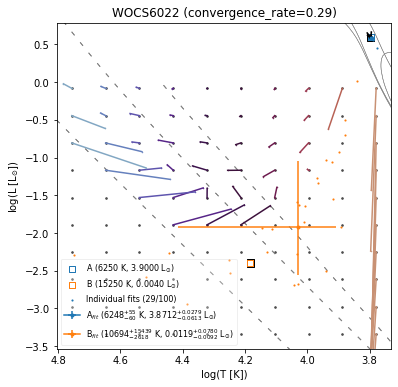

In [ ]:
importlib.reload(st)
'''
Stellar parameters and flux error values are taken from the WOCS6022 star in M67. 
'''
frac_err = [0.11973442, 0.11973442, 0.02486792, 0.02302585, 0.01565758,
       0.0058596 , 0.00384279, 0.00441559, 0.0044849 , 0.00407437,
       0.18696991, 0.00500789, 0.00503038, 0.00531034, 0.00555243,
       0.00574088, 0.00851752, 0.00080766, 0.00080397, 0.00602147,
       0.00582179, 0.00569675, 0.0058333 , 0.00406159, 0.005807  ,
       0.00552801, 0.00558459, 0.00554189, 0.00531678, 0.00548177,
       0.00506979, 0.00487892, 0.00472433, 0.00474433, 0.01749965,
       0.00075697, 0.00075137, 0.00431381, 0.00392895, 0.00362299,
       0.00326196, 0.00333563, 0.00326418, 0.00313196, 0.00318977,
       0.00304362, 0.00307255, 0.003144  , 0.00319828, 0.00327633,
       0.0033039 , 0.00360087, 0.00335565, 0.00365031, 0.00376557,
       0.00389125, 0.00400811, 0.0040805 , 0.00418774, 0.00421027,
       0.00447786, 0.004972  , 0.00532831, 0.00182683, 0.0056491 ,
       0.00584375, 0.00587035, 0.00096199, 0.00640621, 0.00723591,
       0.00313366, 0.01842068, 0.02026275, 0.01934171, 0.02071304,
       0.02425417, 0.24591609, 0.39880774]
x = np.array([3.17055506, 3.20628604, 3.31888766, 3.35122191, 3.42840504,
       3.60321457, 3.61362852, 3.6146239 , 3.62423003, 3.6333031 ,
       3.63339145, 3.63410048, 3.64477525, 3.6546022 , 3.66356118,
       3.67250403, 3.67413556, 3.67472485, 3.67655363, 3.68147125,
       3.69118293, 3.69942974, 3.70770064, 3.71093565, 3.71665957,
       3.72456406, 3.73214055, 3.74049179, 3.7485045 , 3.75661172,
       3.76426518, 3.77229991, 3.77885694, 3.7865519 , 3.7882478 ,
       3.7919847 , 3.79281957, 3.79300697, 3.80018805, 3.80687208,
       3.81314242, 3.81998232, 3.82023771, 3.82690262, 3.83317632,
       3.83984289, 3.84559957, 3.85256872, 3.85803464, 3.86402166,
       3.87014934, 3.87514528, 3.88075973, 3.88762222, 3.89253317,
       3.89806601, 3.90345218, 3.90923061, 3.91467934, 3.92004577,
       3.92482289, 3.92987988, 3.93437563, 3.93501118, 3.93996292,
       3.94538848, 3.95000739, 3.95135135, 3.9543327 , 3.95892194,
       3.98104513, 4.09166696, 4.22063102, 4.33425264, 4.52538174,
       4.6630221 , 5.06298789, 5.34416229])

WOCS6022 = st.Binary( T_A = 6250*u.K,
                    L_A = 3.9*u.solLum,
                    T_B = 15250*u.K,
                    L_B = 0.004 *u.solLum,
                    frac_err=frac_err,
                    seed=2,
                    D=10 * u.pc,
                    x=x,
                    name='WOCS6022')
WOCS6022.estimate_errors(niter=100,                    
                       verbose=True,
                       threshold_primary_match=0.10)
WOCS6022.evaluate_pseudo_secondaries(grid_size=10, 
                                niter=100, 
                                refit=False)
WOCS6022.plot_error_and_pseudo_secondaries()


WOCS12010: Grid params :   0%|          | 0/100 [00:00<?, ?it/s]

WOCS12010
---------
T_in  = [6250.000000]	 [11000.000000]
L_in  = [2.800000]	 [0.023000]
T_fit = [6222.247427 +133.147538-255.478056]	[10291.792132 +9790.854783-2565.926320]
L_fit = [2.731571 +0.072073-0.288562]	[0.025636 +0.339569-0.021425]
Convergence rate:0.50


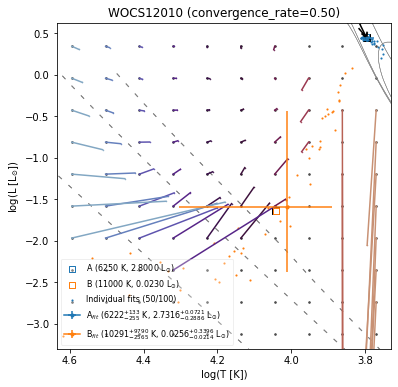

In [ ]:
importlib.reload(st)
'''
Stellar parameters and flux error values are taken from the WOCS12010 star in M67. 
'''
frac_err = [0.14736545, 0.20262749, 0.14736545, 0.00921034, 0.00921034,
        0.00644724, 0.01381551, 0.44780675, 0.00640698, 0.00456946,
        0.00474791, 0.00477423, 0.00455403, 0.06723548, 0.00529965,
        0.44780675, 0.00547381, 0.00589467, 0.00616723, 0.00654381,
        0.00091225, 0.00091064, 0.00692396, 0.00672395, 0.00656999,
        0.00681815, 0.00472486, 0.00669393, 0.00655255, 0.03407826,
        0.00682425, 0.44780675, 0.00646443, 0.00641906, 0.00663619,
        0.0059233 , 0.00568793, 0.00555747, 0.00556699, 0.02947309,
        0.00516419, 0.0045756 , 0.00422393, 0.00370187, 0.00367897,
        0.00360057, 0.00347306, 0.00349483, 0.00350976, 0.00360754,
        0.00374697, 0.00384526, 0.00401906, 0.00407334, 0.00444411,
        0.00417696, 0.00461041, 0.00471624, 0.00481233, 0.00497033,
        0.00503035, 0.0052776 , 0.00532085, 0.00559503, 0.00603671,
        0.0063745 , 0.00220677, 0.00703291, 0.00751991, 0.0076441 ,
        0.00112587, 0.00830093, 0.00919135, 0.00367703, 0.02118378,
        0.02118378, 0.01657861, 0.01981808, 0.02681035, 0.40709704,
        0.44780675]
x = np.array([3.17055506, 3.18780264, 3.20628604, 3.31888766, 3.35122191,
        3.42840504, 3.5466511 , 3.55035709, 3.60321457, 3.61362852,
        3.6146239 , 3.62423003, 3.6333031 , 3.63339145, 3.63410048,
        3.64043485, 3.64477525, 3.6546022 , 3.66356118, 3.67250403,
        3.67472485, 3.67655363, 3.68147125, 3.69118293, 3.69942974,
        3.70770064, 3.71093565, 3.71665957, 3.72456406, 3.73189906,
        3.73214055, 3.73779467, 3.74049179, 3.7485045 , 3.75661172,
        3.76426518, 3.77229991, 3.77885694, 3.7865519 , 3.7882478 ,
        3.79300697, 3.80018805, 3.80687208, 3.81314242, 3.81998232,
        3.82023771, 3.82690262, 3.83317632, 3.83984289, 3.84559957,
        3.85256872, 3.85803464, 3.86402166, 3.87014934, 3.87514528,
        3.88075973, 3.88762222, 3.89253317, 3.89806601, 3.90345218,
        3.90923061, 3.91467934, 3.92004577, 3.92482289, 3.92987988,
        3.93437563, 3.93501118, 3.93996292, 3.94538848, 3.95000739,
        3.95135135, 3.9543327 , 3.95892194, 3.98104513, 4.09166696,
        4.22063102, 4.33425264, 4.52538174, 4.6630221 , 5.06298789,
        5.34416229])

WOCS12010 = st.Binary( T_A = 6250*u.K,
                    L_A = 2.8*u.solLum,
                    T_B = 11000*u.K,
                    L_B = 0.023 *u.solLum,
                    frac_err=frac_err,
                    seed=2,
                    D=10 * u.pc,
                    x=x,
                    name='WOCS12010')
WOCS12010.estimate_errors(niter=100,                    
                       verbose=True,
                       threshold_primary_match=0.10)
WOCS12010.evaluate_pseudo_secondaries(grid_size=10, 
                                niter=100, 
                                refit=False)
WOCS12010.plot_error_and_pseudo_secondaries()

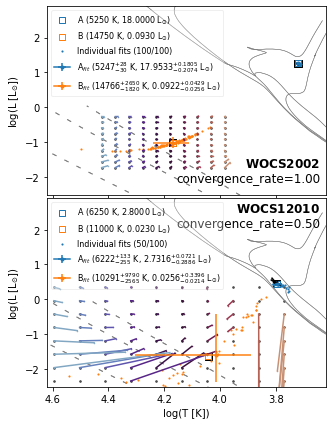

In [ ]:
# fig, ax = plt.subplots(figsize=(5,8), nrows=2, sharex=True)
fig, ax = plt.subplots(figsize=(5,7), nrows=2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.02)

WOCS2002.plot_error_and_pseudo_secondaries(ax=ax[0])
WOCS12010.plot_error_and_pseudo_secondaries(ax=ax[1])

ax[0].set_title(r'$\bf{WOCS2002}$'+'\nconvergence_rate=%.2f'%WOCS2002.convergence_rate,
                 x=0.98,y=0.02, ha='right', va='bottom')
ax[1].set_title(r'$\bf{WOCS12010}$'+'\nconvergence_rate=%.2f'%WOCS12010.convergence_rate,
                 x=0.98,y=0.95, ha='right', va='top')

ax[0].set(xlim=(4.62,3.62), ylim=(-2.52,2.9))
plt.savefig('plots/public/error_estimation.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('plots/public/error_estimation.png', dpi=300, bbox_inches='tight', facecolor='white')

# Logo

In [ ]:
def plot_seds(self, param: str, ax = None) -> None:
    """
    Plots the SED patches on the provided axis.

    Parameters
    ----------
    param : str
        The parameter to color the SED patches.
    ax : plt.Axes, optional
        The axes to plot on. If None, a new figure and axes are created.
    """
    def x_to_logT(x: np.ndarray, logT: float, delta_logT: float, x_new: np.ndarray, buffer: int = 4) -> float:
        """
        Perform a linear interpolation to estimate logT values based on a range of x values.

        Parameters
        ----------
        x : array-like
            The original x values (independent variable).
        logT : float
            The base logT value.
        delta_logT : float
            The range of logT values.
        x_new : np.ndarray
            The new x value for which logT needs to be estimated.
        buffer : int, optional
            A buffer to adjust spacing. Defaults to 4.

        Returns
        -------
        float
            The estimated logT value for the given x_new.
        """
        x1, y1 = x.min(), logT + delta_logT/buffer
        x2, y2 = x.max(), logT - delta_logT/buffer
        logT_new = y1 + (y2-y1) * (x_new-x1) / (x2-x1)
        return logT_new

    def y_to_logL(y: np.ndarray, ymin: float, yptp: float, height: float = 1.2, offset: float = 0.2) -> np.ndarray:
        """
        Convert y values to logL values based on a given height and offset.

        Parameters
        ----------
        y : array-like
            The y values to be converted.
        ymin : float
            The minimum y value.
        yptp : float
            The peak-to-peak range of y values.
        height : float, optional
            The scaling factor for the y values. Defaults to 1.2.
        offset : float, optional
            The offset to adjust the y values. Defaults to 0.2.

        Returns
        -------
        array-like
            The converted logL values.
        """
        y = y - ymin
        y = height * ((1-offset) * y/yptp + offset)
        return y

    if ax is None:
        fig, ax = plt.subplots()

    delta_logT = self.logT_B_list[1]-self.logT_B_list[0]
    df_sed_niter0 = self.df_sed_niter0
    _logL_max = self.logL_B_list.max()
    for idx in range(self.n_B):
        _logT = self.logT_B_list[idx]
        _logL = self.logL_B_list[idx]
        df = df_sed_niter0[df_sed_niter0['id'] == idx].reset_index()
        df['x_patch'] = x_to_logT(self.x, _logT, delta_logT,
                                    self.x, buffer=4)
        df['y_patch'] = np.full(len(self.x), _logL)
        if param == 'ewr_Single':
            df.sort_values(by=param, key=abs, inplace=True)

        # Plotting actual SEDs
        if (idx//4!=1) & (idx//4!=2):
            df_sed = self.df_sed_niter0
            df_sed = df_sed[df_sed['id'] == idx].reset_index()
            if idx==0:
                df_sed0 = df_sed.copy()
            df = df.sort_values(by='x_patch').reset_index()
            x = df.x_patch.values[::-1]
            _filter = (df_sed.y_A > df_sed.y.min())
            y = y_to_logL(df_sed.y_A[_filter],
                            df_sed.y.min(), np.ptp(df_sed.y))
            ax.plot(x[_filter], _logL + y, lw=1, c='C3')
            _filter = (df_sed.y_B > df_sed.y.min())
            y = y_to_logL(df_sed.y_B[_filter],
                            df_sed.y.min(), np.ptp(df_sed.y))
            ax.plot(x[_filter], _logL + y, lw=1, c='C4')

import matplotlib.pyplot as plt
import sed_analysis_tools_docu as st
importlib.reload(st)

logT_B_list = np.linspace(3,4,4)
logL_B_list = np.linspace(-3,0,4)
logT_B_list, logL_B = np.meshgrid(logT_B_list, logL_B_list)
logT_B_list, logL_B_list = logT_B_list.flatten(), logL_B.flatten()

grid = st.Grid(T_A = 10**3.5 *u.K, 
            L_A = 10**-1.5 *u.solLum, 
            logT_B_list = logT_B_list, 
            logL_B_list = logL_B_list, 
            niter=50,
            frac_err=0.001,
            name='logo',
            x=x_realistic)

grid.calculate_params(refit=False)

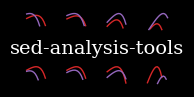

In [63]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(2,1))

plot_seds(grid, param='ewr_Single', ax=ax)

ax.axis('off')
ax.text(0.5, 0.5, 'sed-analysis-tools', fontsize=14, transform=ax.transAxes,
        va='center', ha='center', color='white', family='serif', variant='small-caps')#, weight='bold')
plt.savefig('sphinx/logo.png', dpi=200, bbox_inches='tight')
plt.style.use('default')